In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os


In [113]:
# --- Parámetros conocidos ---

R = 100  # resistencia en ohms
C = 10e-6   # capacitancia en faradios (10 microfarads)
omega_0 = 1 / (R * C)  # frecuencia de corte w0 = 1000Hz (1 kHz)


In [114]:
def seno(t, A, phi, f):
    return A * np.sin(2 * np.pi * f * t + phi)

def ajustar_seno(t, V, f):
    A0 = (np.max(V) - np.min(V)) / 2  # estimación inicial de la amplitud
    phi0 = 0
    popt, _ = curve_fit(lambda t, A, phi: seno(t, A, phi, f), t, V, p0=[A0, phi0])
    return popt  # A, phi


def analizar_archivo(path, f, h_ms):
    df = pd.read_csv(path, usecols=["Time [s]", "CH1 [V]", "CH2 [V]"], skipinitialspace=True)

    Vin = df["CH1 [V]"].values
    Vout = df["CH2 [V]"].values

    # Reconstrucción del tiempo en segundos
    t = np.arange(len(Vin)) * (h_ms / 1000.0)

    A_in, phi_in = ajustar_seno(t, Vin, f)
    A_out, phi_out = ajustar_seno(t, Vout, f)

    # Transferencia
    T = np.abs(A_out / A_in)
    A_dB = 20 * np.log10(T)
    fase_deg = np.degrees(phi_out - phi_in)

    return {"f": f, "T": T, "A_dB": A_dB,"fase_deg": fase_deg}


In [115]:

# --- Parámetros ---
freqs = [170, 170, 100, 50, 270, 370, 470, 570, 670, 770, 870, 970, 1100, 1200, 1500]
hs = [5, 5, 5, 5, 5, 1, 1, 1, 0.5, 0.5, 0.5, 0.2, 0.2, 0.2, 0.2]

# --- Cargar todos los CSV ---
resultados = []
folder = "data/"
filenames = sorted(os.listdir(folder))
for i, filename in enumerate(filenames):
    path = os.path.join(folder, filename)
    resultado = analizar_archivo(path, freqs[i], hs[i])
    resultados.append(resultado)
    

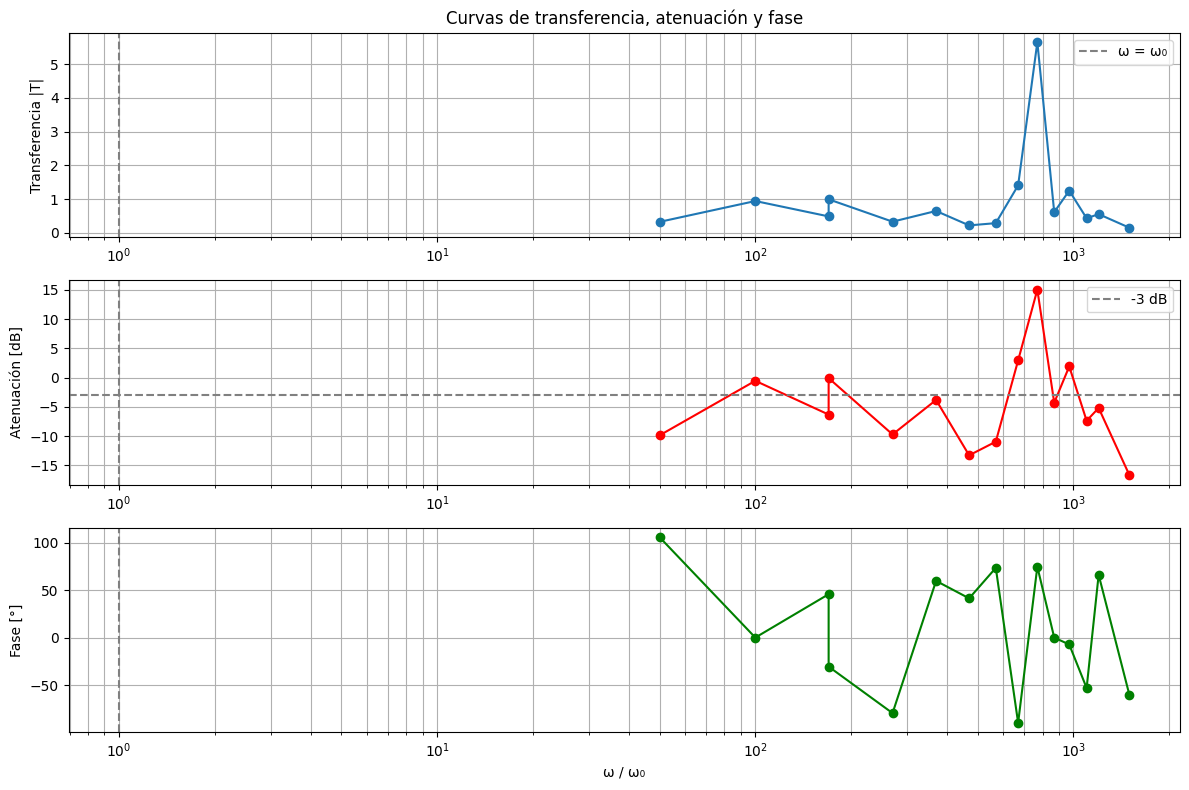

In [116]:
# --- Convertir a DataFrame y graficar ---
df_resultados = pd.DataFrame(resultados).sort_values("f")

# --- Gráficos ---
plt.figure(figsize=(12, 8))

# Transferencia
plt.subplot(3, 1, 1)
plt.plot(df_resultados["f"], df_resultados["T"], 'o-')
plt.axvline(1, color='gray', linestyle='--', label='ω = ω₀')
plt.ylabel("Transferencia |T|")
plt.xscale("log")
plt.grid(True, which='both')
plt.legend()
plt.title("Curvas de transferencia, atenuación y fase")

# Atenuación
plt.subplot(3, 1, 2)
plt.plot(df_resultados["f"], df_resultados["A_dB"], 'o-', color='red')
plt.axhline(-3, color='gray', linestyle='--', label='-3 dB')
plt.axvline(1, color='gray', linestyle='--')
plt.ylabel("Atenuación [dB]")
plt.xscale("log")
plt.grid(True, which='both')
plt.legend()

# Fase (será NaN por ahora)
plt.subplot(3, 1, 3)
plt.plot(df_resultados["f"], df_resultados["fase_deg"], 'o-', color='green')
plt.axvline(1, color='gray', linestyle='--')
plt.xlabel("ω / ω₀")
plt.ylabel("Fase [°]")
plt.xscale("log")
plt.grid(True, which='both')

plt.tight_layout()
plt.show()


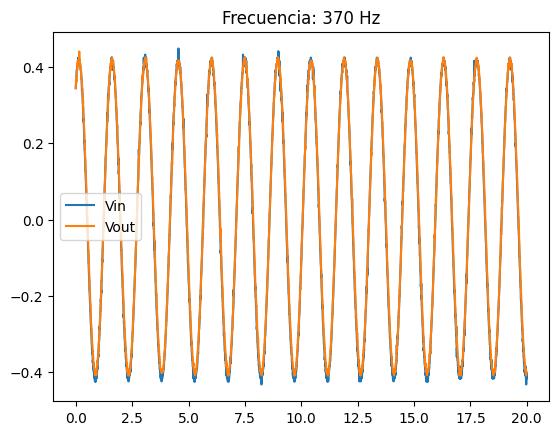

In [ ]:
# Chequeando que las señales estan ok

F = 370
h_ms = 5
path = "data/scope_csv_20_1.csv"

df = pd.read_csv(path, usecols=["Time [s]", "CH1 [V]", "CH2 [V]"], skipinitialspace=True)

Vin = df["CH1 [V]"].values
Vout = df["CH2 [V]"].values

# Reconstrucción del tiempo en segundos
t = np.arange(len(Vin)) * (h_ms / 1000.0)

plt.plot(t, Vin, label='Vin')
plt.plot(t, Vout, label='Vout')
plt.title(f"Frecuencia: {F} Hz")
plt.legend()
plt.show()
